In [3]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [5]:
# Load an empty scene and configure single linearly polarized antennas for
# all transmitters and receivers
scene = load_scene(sionna.rt.scene.simple_street_canyon)
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter
tx = Transmitter("tx", position=[-32,10,32], look_at=[0,0,0])
scene.add(tx)

# Place a receiver (we will not actually use it
# for anything apart from referencing the position)
rx = Receiver("rx", position=[22,52,1.7])
scene.add(rx)

# Place RIS
ris = RIS(name="ris",
          position=[32,-9,32],
          num_rows=100,
          num_cols=100,
          num_modes=1,
          look_at=(tx.position+rx.position)/2) # Look in between TX and RX
scene.add(ris)

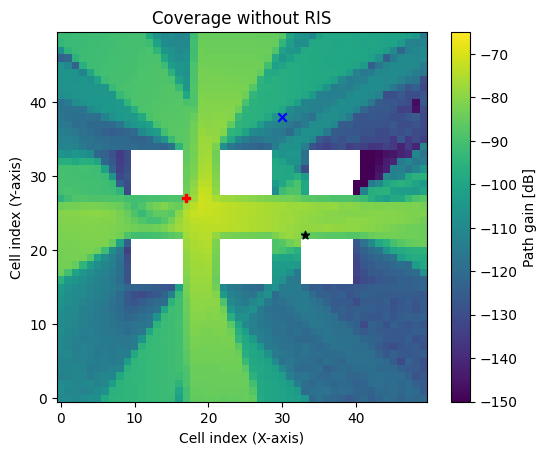

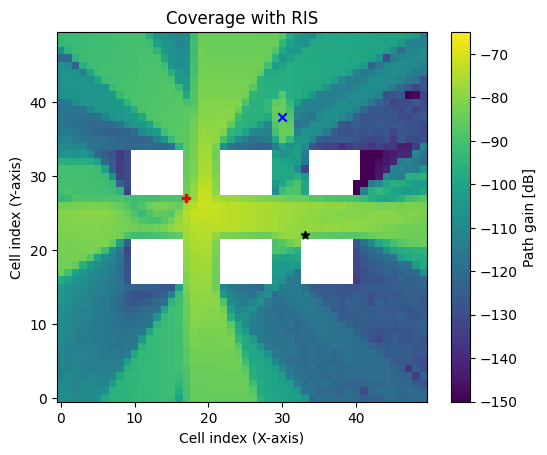

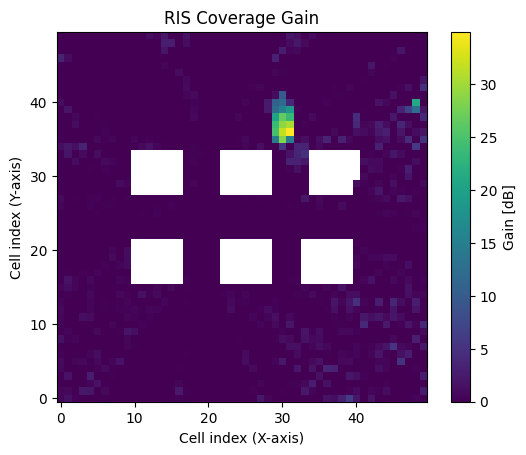

In [8]:
# Configure RIS as phase gradient reflector that reradiates energy
# toward the direction of the receivers
ris.phase_gradient_reflector(tx.position, rx.position)

# Compute coverage map without RIS
cm_no_ris = scene.coverage_map(num_samples=2e6, #increase for better resolution
                        max_depth=5,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        ris=False,
                        cm_cell_size=[4,4],
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,1.5],
                        cm_size=[200,200])
cm_no_ris.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True);
plt.title("Coverage without RIS");

# Compute coverage map with RIS
cm_ris = scene.coverage_map(num_samples=2e6, #increase for better resolution
                        max_depth=5,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        ris=True,
                        cm_cell_size=[4,4],
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,1.5],
                        cm_size=[200,200])
cm_ris.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True);
plt.title("Coverage with RIS");

# Visualize the coverage improvements thanks to the RIS
fig = plt.figure()
plt.imshow(10*np.log10(cm_ris.path_gain[0]/cm_no_ris.path_gain[0]), origin='lower', vmin=0)
plt.colorbar(label='Gain [dB]')
plt.xlabel('Cell index (X-axis)');
plt.ylabel('Cell index (Y-axis)');
plt.title("RIS Coverage Gain");

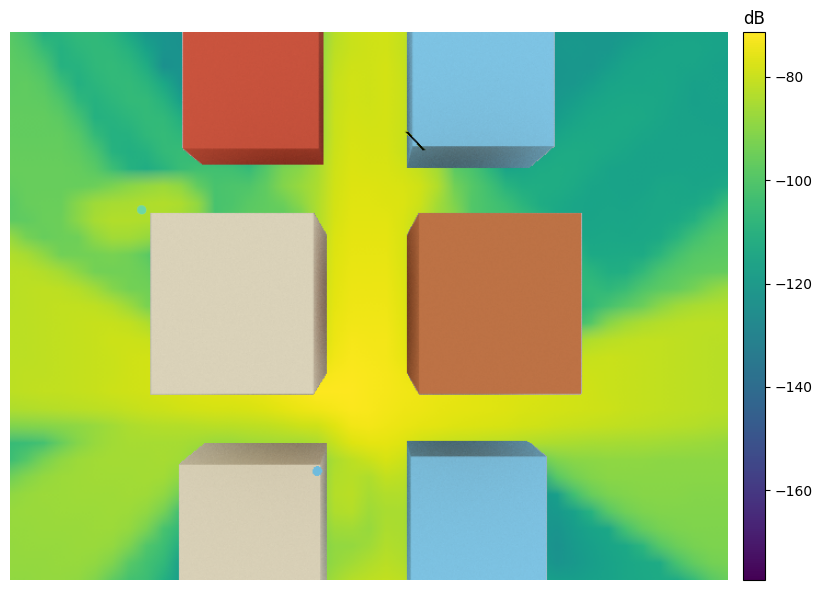

In [9]:
if scene.get("birds-eye") is None:
    scene.add(Camera("birds-eye",
                     position=[0,0,200],
                     look_at=[0,0,0]))
scene.render(camera="birds-eye",
             num_samples=512,
             coverage_map=cm_ris);


In [ ]:
hidden_scene = load_scene()
scene.frequency = 3e9


# Test
